In [97]:
import numpy as np

import pandas as pd

from sklearn import svm
from sklearn.preprocessing import StandardScaler

import os

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

DEVICE = torch.device('cuda')

# 1. Data set

In [98]:
from os import device_encoding
from pyexpat.errors import XML_ERROR_FEATURE_REQUIRES_XML_DTD
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

NUM_PROLIFIC_AUTHORS = 100
NUM_WORDS = 5001 # 5000 valid word indices, plus one for place holder in padding
NUM_VENUES = 466 # 465 valid venues + 1 reserved for null venues

class CustomDataset(Dataset):
    def __init__(self, file_name, data_dir, transform=None, target_transform=None):
        # Get data
        self.data_dir = data_dir
        self.data = pd.read_json(os.path.join(data_dir, file_name))

        # Clean data
        self.data.venue = self.data.venue.map(lambda x: 465 if x == '' else x) # Change "" data to 465, a new cateogry

        # Convert year and venue to numpy array
        self.x_year = self.data.year.to_numpy()[:,np.newaxis]
        self.x_venue = self.data.venue.to_numpy()[:,np.newaxis]

        # Convert abstracts and titles to lists of arrays of words (in numbers)
        abstracts_list = self.data.abstract.to_list()
        self.x_abstract = [np.array(x).astype(np.int32) for x in abstracts_list]
        titles_list = self.data.title.to_list()
        self.x_title = [np.array(x).astype(np.int32) for x in titles_list]

        # Convert y to numpy array
        self.y = self.data.authors.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_year = self.x_year[idx]
        x_venue = self.x_venue[idx]
        x_abstract = self.x_abstract[idx]
        x_title = self.x_title[idx]
        y = self.authors_to_one_hot(self.y[idx])
        return x_year, x_venue, x_abstract, x_title, y

    def authors_to_one_hot(self, authors):
        one_hot = np.zeros(NUM_PROLIFIC_AUTHORS).astype(int)
        a_array = np.array(authors)
        prolific_a_array = a_array[a_array < 100]
        one_hot[prolific_a_array] = 1
        return one_hot

def pad_collate(batch):
    '''
    Custom collate function to combine a batch of samples
    '''
    (x_year, x_venue, x_abstract, x_title, y) = zip(*batch)
    
    # Convert x (year and venue) and y to tensors and pack them
    x_year_tensor = torch.tensor(x_year, device=DEVICE)
    x_venue_tensor = torch.tensor(x_venue, device=DEVICE)
    y_tensor = torch.tensor(y, device=DEVICE)

    # Convert texts to tensors
    x_abstract_tensor = [torch.tensor(x, device=DEVICE) for x in x_abstract]
    x_title_tensor = [torch.tensor(x, device=DEVICE) for x in x_title]

    return x_year_tensor, x_venue_tensor, x_abstract_tensor, x_title_tensor, y_tensor

# Obtain custom dataset and split
dataset = CustomDataset('train.json', './data/')
train_set, val_set = random_split(dataset, [round(len(dataset)*0.7), round(len(dataset)*0.3)])

# Convert split dataset to dataloaders
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=pad_collate)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=pad_collate)


# 2. Model

## 2.1 NN

In [99]:
import torch.nn.functional as F

'''
Define the NN model tailored for the task
'''
class MLP(nn.Module):
    def __init__(self, embed_input_size, other_input_size, embed_vocab, embed_size, 
        hidden_size1, hidden_size2, out_size):
        super().__init__()

        # Embedding layer is used to convert data into one-hot encoding and then pass
        # through a linear layer
        self.embedding_layer = nn.Embedding(embed_vocab, embed_size)

        self.input_layer = nn.Linear(embed_size*embed_input_size + other_input_size, 
            hidden_size1)
        self.hidden_layer = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, out_size)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x_no_embed = x[0]
        x_embed = x[1]
        
        batch_size = x_embed.shape[0]
        embed_out = self.embedding_layer(x_embed)
        # Flatten the new dimension added by embedding
        embed_out = torch.flatten(embed_out, start_dim=1) 

        x = torch.cat((embed_out, x_no_embed), 1)
        
        x = F.relu(self.input_layer(x))
        x = self.dropout(x)
        
        x = F.relu(self.hidden_layer(x))
        x = self.dropout(x)
        
        out = self.output_layer(x)
        
        return out

## 2.2 RNN

In [100]:
import torch.nn as nn
import torch.optim as optim

### 2.2.1 MLP with RNN

In [101]:

class RNN_MLP(nn.Module):
    def __init__(self, rnn_embed_vocab, rnn_embed_size, rnn_hidden_size1, rnn_hidden_size2,
        mlp_embed_input_size, mlp_other_input_size, mlp_embed_vocab, 
        mlp_embed_size, mlp_hidden_dim1, mlp_hidden_dim2, mlp_out_size):
        super().__init__()

        self.embedding_layer = nn.Embedding(rnn_embed_vocab, rnn_embed_size)
        self.rnn1 = nn.RNN(
            input_size=rnn_embed_size, 
            hidden_size=rnn_hidden_size1,
            nonlinearity='tanh',
            )
        self.rnn2 = nn.RNN(
            input_size=rnn_embed_size, 
            hidden_size=rnn_hidden_size2,
            nonlinearity='tanh',
            )
        self.mlp = MLP(
            mlp_embed_input_size, 
            mlp_other_input_size + rnn_hidden_size1 + rnn_hidden_size2, 
            mlp_embed_vocab, 
            mlp_embed_size, 
            mlp_hidden_dim1, 
            mlp_hidden_dim2, 
            mlp_out_size)

    def forward(self, x):
        x_mlp = x[0]
        x_mlp_embed = x[1]
        x_rnn1 = x[2] # assuming list of variable sized tensors
        x_rnn2 = x[3] # assuming list of variable sized tensors

        # Get lengths
        x_rnn1_lens = [len(x) for x in x_rnn1]
        x_rnn2_lens = [len(x) for x in x_rnn2]

        # Pad variable length tensors with new word index at 5000
        x_rnn1_pad = pad_sequence(x_rnn1, batch_first=True, padding_value=NUM_WORDS-1)
        x_rnn2_pad = pad_sequence(x_rnn2, batch_first=True, padding_value=NUM_WORDS-1)

        # Embed inputs one by one in the list
        x_rnn1_pad = self.embedding_layer(x_rnn1_pad)
        x_rnn2_pad = self.embedding_layer(x_rnn2_pad)
        
        # Convert the list of tensors into a packed sequence
        x_rnn1_pack = pack_padded_sequence(x_rnn1_pad, x_rnn1_lens, batch_first=True, enforce_sorted=False)
        x_rnn2_pack = pack_padded_sequence(x_rnn2_pad, x_rnn2_lens, batch_first=True, enforce_sorted=False)
        
        # Run the model
        rnn_out1 = self.rnn1(x_rnn1_pack)
        rnn_out2 = self.rnn2(x_rnn2_pack)

        # Unpack the output seqeunce
        out_padded1, out_length1 = pad_packed_sequence(rnn_out1[0], batch_first=True)
        out_padded2, out_length2 = pad_packed_sequence(rnn_out2[0], batch_first=True)

        # Get orignal output by removing the padding
        out_padded1 = out_padded1[np.arange(len(out_length1)), out_length1-1, :]
        out_padded2 = out_padded2[np.arange(len(out_length2)), out_length2-1, :]

        # Feed RNN output to MLP and get mlp output
        mlp_out = self.mlp((torch.cat((out_padded1, out_padded2, x_mlp), 1), x_mlp_embed))
        
        return mlp_out

### 2.2.2 MLP with attention based GRU

In [102]:
# class AttentionalGRUClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(AttentionalGRUClassifier, self).__init__()
#         self.gru = nn.GRU(input_size, hidden_size)
#         self.h2o = nn.Linear(hidden_size, output_size) 
#         self.att = nn.Linear(hidden_size, 1) 
        
#     def forward(self, input_sequence):
#         # process the input sequence into a sequence of RNN hidden states
#         states, _ = self.gru(input_sequence)
#         # compute attention scores to each RNN hidden state (we use a linear function)
#         att_scores = self.att(states)
#         # rescale the attention scores using a softmax, so they sum to one
#         alpha = F.softmax(att_scores, dim=0)
#         # compute the "c" vector as a weighted combination of the RNN hidden states
#         c = torch.sum(torch.mul(states, alpha), dim=0)
#         # now couple up the c state to the output, and compute log-softmax
#         output = self.h2o(c.view(1, -1)) 
#         output = F.log_softmax(output, dim=1)
#         return output, alpha

GRU Traning code

In [103]:


# model = AttentionalGRUClassifier(n_letters, n_hidden, n_categories)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# criterion = nn.NLLLoss()

# start = time.time()
# all_losses_att = []
# current_loss = 0

# for iter in range(1, n_iters + 1):
#     category, line, category_tensor, line_tensor = randomTrainingExample(noise=noise_level)

#     model.zero_grad()
#     output, _ = model.forward(line_tensor)
#     output = torch.squeeze(output, 1) # remove redundant dimension
#     loss = criterion(output, category_tensor)
#     current_loss += loss.item()
#     loss.backward()
#     optimizer.step()

#     # Print iter number, loss, name and guess
#     if iter % print_every == 0:
#         guess, guess_i = categoryFromOutput(output)
#         correct = '✓' if guess == category else '✗ (%s)' % category
#         print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

#     # Add current loss avg to list of losses
#     if iter % plot_every == 0:
#         all_losses_att.append(current_loss / plot_every)
#         current_loss = 0

# 3. Training and Testing

In [104]:
import time

def test(model, criterion, test_loader):
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x_year, x_venue, x_abstract, x_title, y = data

        with torch.no_grad():
            logits = model((x_year, x_venue, x_abstract, x_title))
            predictions = torch.round(torch.sigmoid(logits))
            test_loss += criterion(input=logits, target=y.float()).item()
            test_preds.append(predictions)
            test_labels.append(y)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_mean_accuracy = torch.mean((torch.sum(torch.eq(predictions, y).float(), 1) == 100).float()).item()
    test_mean_loss = test_loss/len(test_loader)

    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_mean_loss, test_mean_accuracy))

    return test_mean_loss, test_mean_accuracy

def train(model, train_loader, val_loader, optimizer, n_epochs=10, model_name='model'):
    """
    Generic training loop for supervised multiclass learning
    """
    LOG_INTERVAL = 250
    running_loss, running_accuracy, running_test_accuracy = list(), list(), list()
    start_time = time.time()
    criterion = nn.BCEWithLogitsLoss()
    current_best_acc = np.Inf
    current_best_model = None

    for epoch in range(n_epochs):  # Loop over training dataset `n_epochs` times

        epoch_loss = 0.

        for i, data in enumerate(train_loader):  # Loop over elements in training set

            x_year, x_venue, x_abstract, x_title, y = data

            logits = model((x_year, x_venue, x_abstract, x_title))

            predictions = torch.round(torch.sigmoid(logits))
            train_acc = torch.mean((torch.sum(torch.eq(predictions, y).float(), 1) == 100).float()).item()

            loss = criterion(input=logits, target=y.float())

            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next iteration

            # ============================================================================
            # You can safely ignore the boilerplate code below - just reports metrics over
            # training and test sets

            running_loss.append(loss.item())
            running_accuracy.append(train_acc)

            epoch_loss += loss.item()

            if i % LOG_INTERVAL == 0:  # Log training stats
                deltaT = time.time() - start_time
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Current Mean train accuracy {:.5f} | Current data accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                    i, len(train_loader), mean_loss, sum(running_accuracy)/len(running_accuracy), train_acc, deltaT))

        print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test_loss, test_acc = test(model, criterion, val_loader)
        if test_acc < current_best_acc:
            current_best_acc = test_acc
            current_best_model = model.state_dict()

    # Save best model
    torch.save(current_best_model, f"./model/{model_name}.pth")
    print(f"Best model saved with acc {current_best_acc} at ./model/{model_name}.pth")
        
    return running_loss, running_accuracy

#### Train MLP model

In [88]:
mlp_model = MLP(
    embed_input_size=1, 
    other_input_size=1, 
    embed_vocab=NUM_VENUES, 
    embed_size=NUM_VENUES//2, 
    hidden_size1=256, 
    hidden_size2=128, 
    out_size=100).to(DEVICE)
    
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-2)
mlp_loss, mlp_acc = train(mlp_model, train_dataloader, val_dataloader, 
    optimizer, n_epochs=1, model_name='mlp_temp')


[TEST] Mean loss 0.6937 | Accuracy 0.0000


0.6937353945960684

#### Load MLP model for testing

In [90]:
model_path = './model/mlp.pth'

mlp_model = MLP(
    embed_input_size=1, 
    other_input_size=1, 
    embed_vocab=NUM_VENUES, 
    embed_size=NUM_VENUES//2, 
    hidden_size1=256, 
    hidden_size2=128, 
    out_size=100).to(DEVICE)
mlp_model.load_state_dict(torch.load(model_path))

optimizer = torch.optim.SGD(mlp_model.parameters(), lr=1e-2, momentum=0.9)

criterion = nn.BCEWithLogitsLoss()
a = test(mlp_model, criterion, val_dataloader)

[TEST] Mean loss 0.0259 | Accuracy 0.6724


#### Train MLP model with RNN

In [105]:
mlp_model = RNN_MLP(
    rnn_embed_vocab=NUM_WORDS,
    rnn_embed_size=NUM_WORDS//2,
    rnn_hidden_size1=256,
    rnn_hidden_size2=32,

    mlp_embed_input_size=1, 
    mlp_other_input_size=1, 
    mlp_embed_vocab=NUM_VENUES, 
    mlp_embed_size=NUM_VENUES//2, 
    mlp_hidden_dim1=256, 
    mlp_hidden_dim2=128, 
    mlp_out_size=100).to(DEVICE)
    
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=1e-2, momentum=0.9)
# optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-2)
mlp_loss, mlp_acc = train(mlp_model, train_dataloader, val_dataloader, optimizer, n_epochs=20)

[TRAIN] Epoch 0 [0/283]| Mean loss 0.6952 | Current Mean train accuracy 0.00000 | Current data accuracy 0.00000 | Time 2.18 s


#### Load MLP model with RNN for testing

In [ ]:
# ...

#### Train MLP model with attention based GRU

In [ ]:
# ...

#### Load MLP model with attention based GRU for testing

In [ ]:
# ...

#### Plot training graphs

Text(0, 0.5, 'Cross-entropy Loss (Train)')

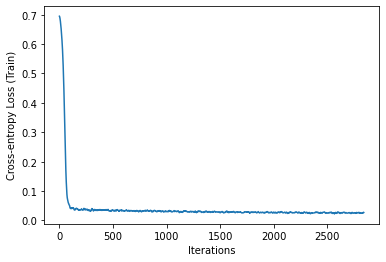

In [57]:
from scipy.signal import savgol_filter  # Smooth spiky curves
import matplotlib.pyplot as plt
running_loss_smoothed = savgol_filter(mlp_loss, 21, 3)
running_acc_smoothed = savgol_filter(mlp_acc, 21, 3)

plt.plot(running_loss_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss (Train)')

(0.2, 1.0)

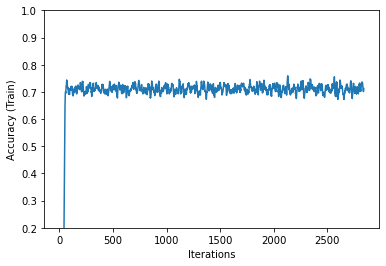

In [58]:
plt.plot(running_acc_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (Train)')
plt.ylim(0.2,1.)